
# Explorartory data analysis

Exploratory data analysis is an important part of any data science projects. According to [Forbs](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=67e543e86f63), it accounts for about 80% of the work of data scientists. Thus, we are going to pay out attention to that part.
In the notebook are given data description, cleaning, variables preparation, and CTR calculation and visualization. 

---

In [1]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import gc

%matplotlib inline

Given that file occupies 5.9G and has 40 mln rows we are going to read only a few rows to glimpse at data.

In [2]:
filename = 'data/train.csv'

! echo 'Number of lines in "train.csv":'
! wc -l {filename}
! echo '"train.csv" file size:'
! du -h {filename}

Number of lines in "train.csv":
 40428968 data/train.csv
"train.csv" file size:
5.9G	data/train.csv


In [3]:
dataset_5 = pd.read_csv('data/train.csv', nrows=5)
dataset_5.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [4]:
print("Number of columns: {}\n".format(dataset_5.shape[1]))

Number of columns: 24



---
## Data preparation

* Column `Hour` has a format `YYMMDDHH` and has to be converted.
* It is necessary to load only `click` and `hour` columns for `CTR` calculation. 
* For data exploration purposes we also calculate `hour` and build distributions of `CTR` by `hour` and `weekday`
---

In [5]:
pd.to_datetime(dataset_5['hour'], format='%y%m%d%H')
# custom_date_parser = lambda x: pd.datetime.strptime(x, '%y%m%d%H')

0   2014-10-21
1   2014-10-21
2   2014-10-21
3   2014-10-21
4   2014-10-21
Name: hour, dtype: datetime64[ns]

In [6]:
row_num = 40428967
# to read 10% of data
skip = sorted(random.sample(range(1, row_num), round(0.9 * row_num)))
data_set = pd.read_csv('data/train.csv',
                       header=0,
                       skiprows=skip,
                       usecols=['click', 'hour'])
data_set['hour'] = pd.to_datetime(data_set['hour'], format='%y%m%d%H')

In [7]:
data_set.isna().sum()

click    0
hour     0
dtype: int64

In [8]:
data_set.shape

(4042897, 2)

In [9]:
round(100 * data_set.click.value_counts() / data_set.shape[0])

0    83.0
1    17.0
Name: click, dtype: float64

In [10]:
data_set.hour.dt.date.unique()

array([datetime.date(2014, 10, 21), datetime.date(2014, 10, 22),
       datetime.date(2014, 10, 23), datetime.date(2014, 10, 24),
       datetime.date(2014, 10, 25), datetime.date(2014, 10, 26),
       datetime.date(2014, 10, 27), datetime.date(2014, 10, 28),
       datetime.date(2014, 10, 29), datetime.date(2014, 10, 30)],
      dtype=object)

### Data preparation for CTR time series graph

In [11]:
df_CTR = data_set.groupby('hour').agg({
    'click': ['count', 'sum']
}).reset_index()
df_CTR.columns = ['hour', 'impressions', 'clicks']
df_CTR['CTR'] = df_CTR['clicks'] / df_CTR['impressions']

In [12]:
# del data_set
# gc.collect()

Text(0.5, 1.0, 'Hourly CTR for period  2014/10/21 and 2014/10/30')

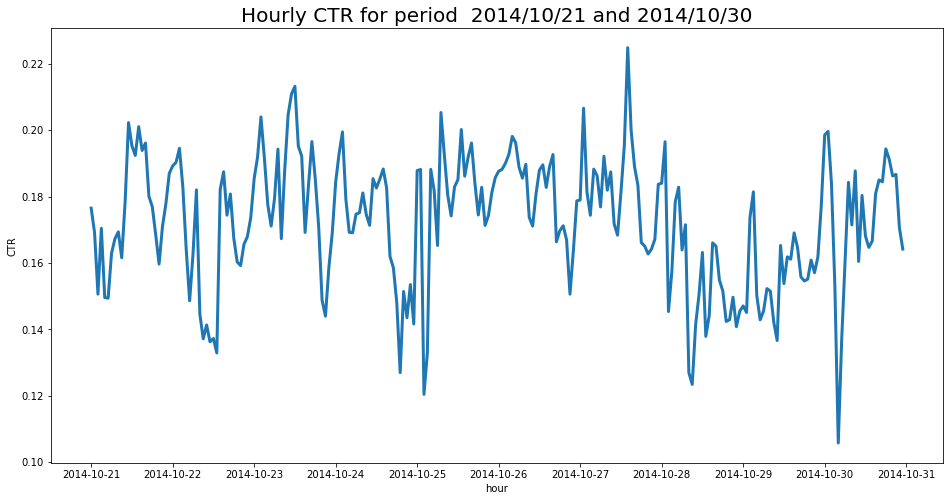

In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=[16, 8])
sns.lineplot(x='hour', y='CTR', data=df_CTR, linewidth=3)
plt.title('Hourly CTR for period  2014/10/21 and 2014/10/30', fontsize=20)

### Data preparation for CTR by hours graph

In [14]:
df_CTR['h'] = df_CTR.hour.dt.hour
df_CTR_h = df_CTR[['h', 'impressions',
                   'clicks']].groupby('h').sum().reset_index()
df_CTR_h['CTR'] = df_CTR_h['clicks'] / df_CTR_h['impressions']

df_CTR_h_melt = pd.melt(df_CTR_h,
                        id_vars='h',
                        value_vars=['impressions', 'clicks'],
                        value_name='count',
                        var_name='type')

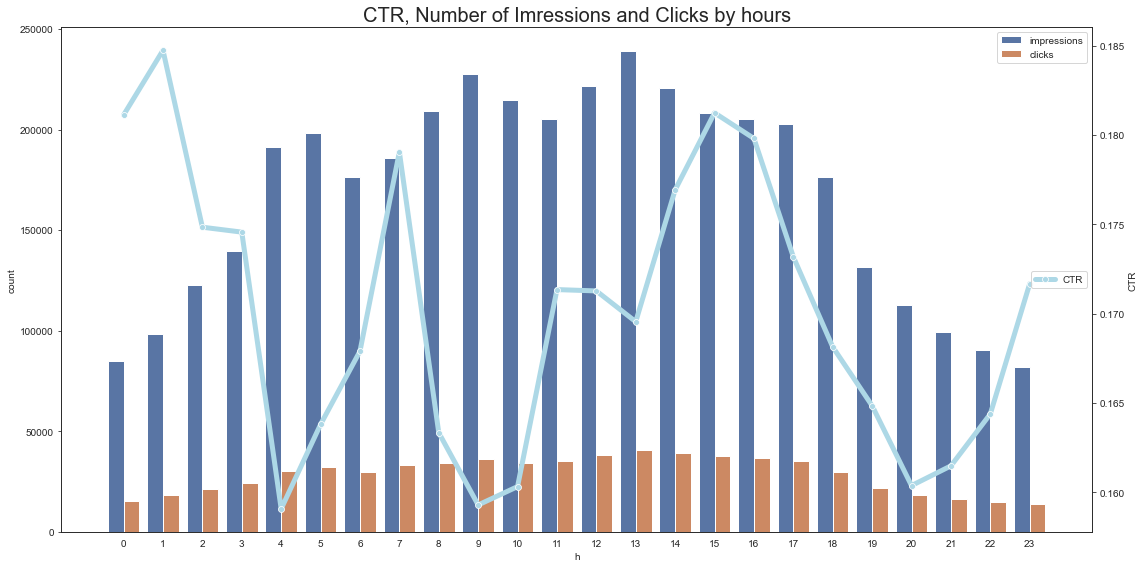

In [15]:
plt.figure(figsize=[16, 8])
sns.set_style("white")
g1 = sns.barplot(x='h',
                 y='count',
                 hue='type',
                 data=df_CTR_h_melt,
                 palette="deep")
g1.legend(loc=1).set_title(None)
ax2 = plt.twinx()
sns.lineplot(x='h',
             y='CTR',
             data=df_CTR_h,
             palette="deep",
             marker='o',
             ax=ax2,
             label='CTR',
             linewidth=5,
             color='lightblue')
plt.title('CTR, Number of Imressions and Clicks by hours', fontsize=20)
ax2.legend(loc=5)
plt.tight_layout()

### Data preparation for CTR by weekday graph

In [16]:
df_CTR['weekday'] = df_CTR.hour.dt.day_name()
df_CTR['weekday_num'] = df_CTR.hour.dt.weekday
df_CTR_w = df_CTR[['weekday', 'impressions',
                   'clicks']].groupby('weekday').sum().reset_index()
df_CTR_w['CTR'] = df_CTR_w['clicks'] / df_CTR_w['impressions']
df_CTR_w_melt = pd.melt(df_CTR_w,
                        id_vars='weekday',
                        value_vars=['impressions', 'clicks'],
                        value_name='count',
                        var_name='type')

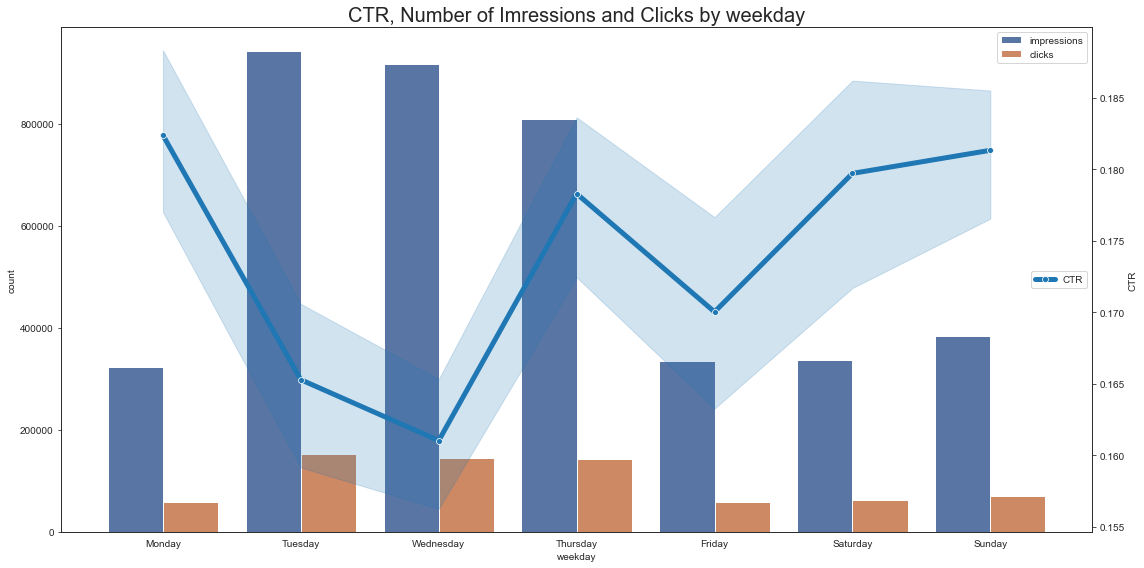

In [17]:
plt.figure(figsize=[16, 8])
sns.set_style("white")
g1 = sns.barplot(x='weekday',
                 y='count',
                 hue='type',
                 data=df_CTR_w_melt.sort_values('weekday'),
                 palette="deep",
                 order=[
                     'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                     'Saturday', 'Sunday'
                 ])
g1.legend(loc=1).set_title(None)
ax2 = plt.twinx()
sns.lineplot(x='weekday',
             y='CTR',
             data=df_CTR.sort_values(by='weekday_num'),
             palette="deep",
             marker='o',
             ax=ax2,
             label='CTR',
             linewidth=5,
             sort=False)
plt.title('CTR, Number of Imressions and Clicks by weekday', fontsize=20)
ax2.legend(loc=5)
plt.tight_layout()

### Normality test

In [18]:
from scipy.stats import normaltest, shapiro


def test_interpretation(stat, p, alpha=0.05):
    """
        Outputs the result of statistical test comparing test-statistic and p-value
    """
    print('Statistics=%.3f, p-value=%.3f, alpha=%.2f' % (stat, p, alpha))
    if p > alpha:
        print('Sample looks like from normal distribution (fail to reject H0)')
    else:
        print('Sample is not from Normal distribution (reject H0)')

In [19]:
stat, p = shapiro(df_CTR.CTR)
test_interpretation(stat, p)

Statistics=0.981, p-value=0.003, alpha=0.05
Sample is not from Normal distribution (reject H0)


In [20]:
stat, p = normaltest(df_CTR.CTR)
test_interpretation(stat, p)

Statistics=8.091, p-value=0.018, alpha=0.05
Sample is not from Normal distribution (reject H0)


---
## Summary

* Number of rows: 40428967
* Date duration: 10 days between 2014/10/21 and 2014/10/30. Each day has 24 hours
* No missing values in variables `click` and `hour`
* For simplicity, analysis is provided for 10% of the data. And as soon as the notebook is finalized, it will be re-run for all available data. And as soon as the hour aggregation takes place, the raw data source is deleted
* Three graphs are provided: 
    * CTR time serirs for all data duration
    * CTR, impressions, and click counts by hour
    * CTR, impressions, and click counts by weekday
* Average `CTR` value is **17%**
* Most of the `Impressions` and `Clicks` are appeared on Tuesday, Wednesday and Thursday. But highest `CTR` values is on Monday and Sunday
* The normality in `CTR` time-series is **rejected** by two tests
---

## Hypothesis: 
There is a seasonality in `CTR` by an `hour` and `weekday`. For instance, `CTR` at hour 21 is lower than `CTR` at hour 14 which can be observed from graphs. Ideally, it is necessary to use 24-hour lag for anomaly detection. It can be implemented by comparing, for instance, hour 1 at day 10 with an average value of hour 1 at days 3, 4, 5, 6, 7, 8, 9 (one week), etc. One week is chosen because averaging of whole week smooth weekday seasonality: Monday and Sunday are different from Tuesday and Wednesday, but there is no big difference between whole weeks. Additional improvement can be done by the use of the median for central tendency instead of a simple averaging because averaging is biased towards abnormal values.